# **RestoFindAI Chatbot**

This assignment is to chatbot to recommend best restaurants in Bangalore based on user prefrences using LLM.


### **Project Background**

In today's digital and fast-moving age, dining out has become the go-to option for many, and a plethora of restaurants are now available. But navigating through endless restaurant options and finding that perfect, personalized dining experience? That's where things get tricky. To address this, we have developed RestoFindAI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery, and a truly personalized dining experience.

### **General Information**

**Background**

In today's digital and fast-moving age, dining out has become the go-to option for many, and a plethora of restaurants are now available. But navigating through endless restaurant options and finding that perfect, personalized dining experience? That's where things get tricky. To address this, we have developed RestoFindAI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery, and a truly personalized dining experience.

**Dataset**

  Sourced *zomato.csv* dataset from [Kaggle](https://www.kaggle.com/datasets/absin7/zomato-bangalore-dataset?select=zomato.csv) source.
  Clean up done to remove unintended data and also basic cleanup (Ref:# *zomato_dataset_cleanup.ipynb*)

  Clean up dataset (*cleaned_zomato.csv*) is being used in this assignment which have below columns:

*   address --> Restaurant Address
*   name    --> Restaurant Name
*   online_order --> Does restaurant have online order facility or not
*   book_table --> Does restaurant have facility to book table in advance
*   rating --> Rating if restaurant out of 5
*   votes --> No. of reviews
*   phone --> Contact numbers of restaurant
*   location --> Restaurant location/neighborhood
*   rest_type --> Type of restaurant like casual dining, cafe
*   dish_liked --> Dishes which most people liked
*   cuisines --> Cuisines restaurant have
*   cost_for_two --> Approx cost of two people


### **Installing & Importing all the important libraries**

In [24]:
# Install OpenAI library
!pip install -U -q openai tenacity

In [25]:
# Import the libraries
import pandas as pd
from IPython.display import display, HTML
from google.colab import drive
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

### **Data Preparation and initial assesment**
Load dataset, define default parameters


In [26]:
pd.set_option('display.width', 100)      # Set the display width to control the output width

In [27]:
# Mount google drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML_AI/GenAI Assignment One')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cleaned_zomato.csv  ResoFindAI_ChatBot_Project.pdf  zomato_dataset_cleanup.ipynb
OPENAI_API_Key.txt  RestoFindAI_Chatbot.ipynb


In [28]:
df = pd.read_csv('cleaned_zomato.csv')   # Read the dataset and read the cleaned Zomato Dataset
df

,address,name,online_order,book_table,rating,votes,phone,location,rest_type,dish_liked,cuisines,cost_for_two
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,"080 42297555, +91 9743772233",Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,"+91 8026612447, +91 9901210005",Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8592,"Unit 04-01, 4th floor, Ascendas Park Square Ma...",Chung Wah,No,No,2.5,73,+91 9535948061,"ITPL Main Road, Whitefield",Casual Dining,Manchow Soup,"Chinese, Momos",800.0
8593,"107/PA, ITPL Main Road, Whitefield, Bangalore",Nawabs Empire,No,No,3.2,5,+91 8123358857,"ITPL Main Road, Whitefield",Quick Bites,NaN,"North Indian, Chinese, Arabian, Momos",300.0
8594,"Cessna Business Park, Sarjapur Marathahalli O...",Nook - Aloft Bengaluru Cessna Business Park,No,Yes,4.2,411,"+91 9663517066, +91 9686861135",Bellandur,Casual Dining,"Chicken Quesadilla, Naan, Breakfast Buffet, Ch...","North Indian, Continental, Asian",1800.0
8595,"44, Kodigehalli to Hoodi Main Road, Mahadevapu...",SeeYa Restaurant,No,No,3.3,4,+91 9164562939,KR Puram,Quick Bites,NaN,"North Indian, Kerala, Chinese",350.0


In [29]:
# Get unique locations to a list to help validating user inputs
unique_locations = df.location.unique().tolist()
print(unique_locations)

['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar', 'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar', 'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market', 'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli', 'Electronic City', 'Sarjapur Road', 'Wilson Garden', 'Shanti Nagar', 'Koramangala 5th Block', 'Richmond Road', 'HSR', 'Koramangala 7th Block', 'Bellandur', 'Marathahalli', 'Whitefield', 'Old Airport Road', 'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'MG Road', 'Brigade Road', 'Lavelle Road', 'Church Street', 'Ulsoor', 'Residency Road', 'Shivajinagar', 'Infantry Road', 'St. Marks Road', 'Cunningham Road', 'Race Course Road', 'Commercial Street', 'Vasanth Nagar', 'Domlur', 'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar', 'Old Madras Road', 'Seshadripuram', 'Kammanahalli', 'Koramangala 6th Block', 'Majestic', 'Langford Town', 'Central Bangalore', 'Brookefield', 'ITPL Main Road, Whitefield', 'Varthur Main Road, Whitefield', 'Kor

In [30]:
# Get uniqie cuisines to a list to help validating user inputs
unique_cuisines_set = set()
for cuisines_str in df['cuisines'].dropna():
    for cuisine in cuisines_str.split(','):
        cuisine = cuisine.strip()
        if cuisine:
          unique_cuisines_set.add(cuisine)

unique_cuisines = list(unique_cuisines_set)
print(unique_cuisines)

['Pizza', 'Indonesian', 'Sindhi', 'Ice Cream', 'Afghani', 'Vietnamese', 'Middle Eastern', 'Bihari', 'Kerala', 'Maharashtrian', 'Mongolian', 'Juices', 'Assamese', 'Portuguese', 'North Indian', 'Oriya', 'Wraps', 'Turkish', 'Parsi', 'Grill', 'British', 'Russian', 'Andhra', 'Steak', 'Asian', 'Mughlai', 'Coffee', 'Tea', 'Modern Indian', 'Chinese', 'Salad', 'Fast Food', 'Korean', 'Kebab', 'Rolls', 'Healthy Food', 'Gujarati', 'Tibetan', 'Desserts', 'Hyderabadi', 'Thai', 'Cafe', 'Sandwich', 'BBQ', 'Arabian', 'Continental', 'Australian', 'Iranian', 'Charcoal Chicken', 'Lebanese', 'Konkan', 'Roast Chicken', 'Mediterranean', 'Goan', 'South Indian', 'Hot dogs', 'Momos', 'Mangalorean', 'Paan', 'Sri Lankan', 'American', 'Cantonese', 'Raw Meats', 'Biryani', 'Sushi', 'South American', 'European', 'Singaporean', 'Burger', 'Spanish', 'African', 'Malaysian', 'Afghan', 'Drinks Only', 'Italian', 'Greek', 'Awadhi', 'Bohri', 'Mithai', 'Rajasthani', 'Bubble Tea', 'Seafood', 'Kashmiri', 'Naga', 'Japanese', 'Ch

### **System Design**

#### **Approach**:


1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 5 restaurants that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect restaurant.

#### **Building the Chatbot**

System design for RestoFindAI chatbot

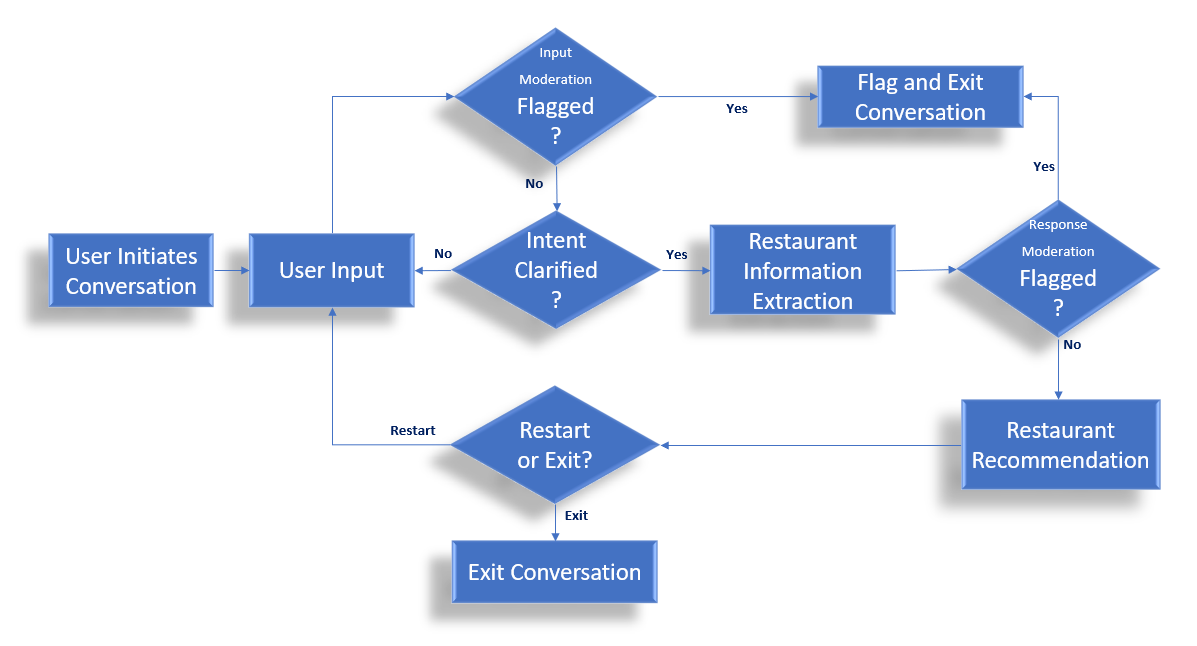

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not - Location, Cuisine, Budget, Order Online, Book Table facilty.
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_restaurants_with_user()`: This function compares the user's profile with the retaurants available and come back with the top 5 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

### **Implementation**

#### **Read OPENAI API Key**

In [31]:
#Read the OpenAI API key
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

#### **Implementing Intent Clarity and Intent Confirmation Layers**

##### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [32]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {'Cuisine': "South Indian",
                        'Location':"Whitefield",
                        'OnlineOrderFacilityRequired': "No",
                        'BookTableFacilityRequired': "No",
                        'BudgetForTwo':"500"}

    example_user_req = {'Cuisine': "_",
                        'Location': "_",
                        'OnlineOrderFacilityRequired': "_",
                        'BookTableFacilityRequired': "_",
                        'BudgetForTwo':"_"}

    system_message = f"""
    You are an intelligent restaurant expert and your goal is to find the best restaurant for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to fill the values for the different keys ('Cuisine','Location','OnlineOrderFacilityRequired','BookTableFacilityRequired','BudgetForTwo') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {{'Cuisine': 'values','Location': 'values','OnlineOrderFacilityRequired': 'values','BookTableFacilityRequired': 'values','BudgetForTwo': 'values'}}
    The value for 'BudgetForTwo' should be a numerical value extracted from the user's response.
    The values for 'Cuisine' and 'Location' should be a string value extracted from the user's response.
    The values for 'OnlineOrderFacilityRequired' and 'BookTableFacilityRequired' should be a 'Yes' or 'No' based on users response
    All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised:
    - The values for 'Cuisine' and 'Location' should be one of valid string mentioned in the user's response.
    - The value for 'BudgetForTwo' should be a numerical value extracted from the user's response. Range can't be an option.
    - 'BudgetForTwo' value needs to be greater than or equal to 40 INR. If the user says less than that, please mention that there are no restaurants in that range.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in {example_user_req}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary Cuisine preference is unclear. Ask followup questions to understand their needs.
    You are trying to fill the values of all the keys {{'Cuisine','Location','OnlineOrderFacilityRequired','BookTableFacilityRequired','BudgetForTwo'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the user and assistant:

    Assistant: "Hello! I'd love to help you find restaurant in Banaglore City."
    User: "south indian cuisine"
    Assistant: "Which specific location in Bangalore? (Whitefield, Bellandur, Banashankari,Basavanagudi,etc)"
    User: "Whitefield"
    Assistant: "What is your approximate budget for two people?"
    User: "500"
    Assistant: "Should restaurant have online order facility?"
    User: "n"
    Assistant: "Should restaurant have option to book table in advance?"
    User: "nope"
    Assistant: "{example_user_dict}"
    {delimiter}

    {delimiter}
    Start with a short welcome message and encourage the user to share their requirements. Appreciate choice of options.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

##### `get_chat_completions()`:

This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

In [33]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

###### Testing chat completions function

In [34]:
# Testing the OpenAI functions defined above
input_prompt ='You are a restaurant expert, get me quick list of Cuisines in Indian Restaurants?'
messages = [{'role':'user','content':input_prompt}]
get_chat_completions(messages, json_format = True) ## Chat Completions API and return in JSON format

{'output': {'cuisines': ['North Indian',
   'South Indian',
   'Punjabi',
   'Gujarati',
   'Rajasthani',
   'Maharashtrian',
   'Goan',
   'Bengali',
   'Kashmiri',
   'Hyderabadi']}}

##### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [35]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

###### Testing moderation check function

In [36]:
print(moderation_check("I want to eat human."))
print(moderation_check("Find me a restaurant"))

Flagged
Not Flagged


As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget are captured or not. Let's look at the function that helps us verify that.

##### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
   - Cuisine
   - Location
   - Budget for two
   - Whether Order Online facility required
   - Whether book table facility required

In [37]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 5 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'Cuisine': 'values',
    'Location':'values',
    'OnlineOrderFacilityRequired':'values',
    'BookTableFacilityRequired':'values',
    'BudgetForTwo':'values'
    }}
    The values for 'Cuisine' should only be from the allowed values: {unique_cuisines}, ignore case sensitive.
    The values for 'Location' should only be from the allowed values: {unique_locations}, ignore case sensitive.
    The 'BudgetForTwo' key can take only a numerical value.
    The 'OnlineOrderFacilityRequired' and 'BookTableFacilityRequired' should be 'yes' or 'no'.
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    Thought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

##### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right restaurants using dictionary matching.

In [38]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {'Cuisine': "South Indian",
                'Location':"Whitefield",
                'OnlineOrderFacilityRequired': "No",
                'BookTableFacilityRequired': "No",
                'BudgetForTwo':"500"}


    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of BudgetForTwo is also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'Cuisine': 'String',
            'Location':'String',
            'OnlineOrderFacilityRequired':'Yes/No',
            'BookTableFacilityRequired':'Yes/No',
            'BudgetForTwo':'numerical value'
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - Cuisine: 'South Indian' - Location: 'Whitefield' - OnlineOrderFacilityRequired: 'No' - BookTableFacilityRequired: 'No' - BudgetForTwo: 1,000 INR
            output 1: {{'Cuisine': 'South Indian', 'Location': 'Whitefield', 'OnlineOrderFacilityRequired': 'No', 'BookTableFacilityRequired': 'No', 'BudgetForTwo': '1000'}}

            input 2: {{'Cuisine':   'South Indian', 'Location':   'Bellandur', 'OnlineOrderFacilityRequired':   'Yes', 'BookTableFacilityRequired':   'No', 'BudgetForTwo':  '1,000'}}
            output 2: {{'Cuisine': 'South Indian', 'Location': 'Bellandur', 'OnlineOrderFacilityRequired': 'Yes', 'BookTableFacilityRequired': 'No', 'BudgetForTwo': '1000'}}

            input 3: Here is your user profile 'Cuisine': 'North Indian','Location': 'Varthur','OnlineOrderFacilityRequired': 'No','BookTableFacilityRequired': 'Yes','BudgetForTwo': '2000 INR'
            output 3: {{'Cuisine': 'North Indian', 'Location': 'Varthur', 'OnlineOrderFacilityRequired': 'No', 'BookTableFacilityRequired': 'Yes', 'BudgetForTwo': '1000'}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation

###### Testing dictionary_present function

In [39]:
debug_response_assistant_n = """{{'Cuisine':   'andhra', 'Location':   'Marathahalli', 'OnlineOrderFacilityRequired':   'No', 'BookTableFacilityRequired':   'Yes', 'BudgetForTwo':  '5,000 INR'}}"""
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)
type(response_dict_n)

{'Cuisine': 'andhra',
 'Location': 'Marathahalli',
 'OnlineOrderFacilityRequired': 'No',
 'BookTableFacilityRequired': 'Yes',
 'BudgetForTwo': '5000'}

dict

#### **Information Extraction Layers**

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 5 restaurants recommendations based on user's requirements.


##### `compare_restaurants_with_user()`:

This function compares the user's profile with the different restaurants and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter restaurant based on budget, location
    - Filter restaurant based on online order facility and book table facility choice
    - If user not choosed online facility, filter restaurants with Delivery only
    - Return the top 5 restaurants as a JSON-formatted string.

In [40]:
def compare_restaurants_with_user(user_requirements):

    # Extracting user requirements from the input string (assuming it's a dictionary)

    budget_for_two = int(user_requirements.get('BudgetForTwo', '0'))
    preferred_location = user_requirements.get('Location', 'Not Available')
    preferred_cuisine = user_requirements.get('Cuisine', 'Not Available')
    online_order_facility_required = user_requirements.get('OnlineOrderFacilityRequired', 'No')
    book_table_facility_required = user_requirements.get('BookTableFacilityRequired', 'No')

    # budget
    # # Creating a copy of the DataFrame and filtering restaurants based on the budget
    filtered_restaurants = df.copy()
    filtered_restaurants['cost_for_two'] = filtered_restaurants['cost_for_two'].astype(int)
    filtered_restaurants = filtered_restaurants[filtered_restaurants['cost_for_two'] <= budget_for_two].copy()

    filtered_restaurants = filtered_restaurants[filtered_restaurants['location'].astype(str).str.lower().str.contains(preferred_location.lower(), na=False)]
    filtered_restaurants = filtered_restaurants[filtered_restaurants['cuisines'].astype(str).str.lower().str.contains(preferred_cuisine.lower(), na=False)]

    if online_order_facility_required.upper() == "YES":
      filtered_restaurants = filtered_restaurants[filtered_restaurants['online_order'].astype(str).str.lower().str.contains("yes", na=False)]
    else:
      filtered_restaurants = filtered_restaurants[filtered_restaurants['rest_type'].astype(str).str.lower() != "delivery"] # Drop Delivery only restaurants

    if book_table_facility_required.upper() == "YES":
      filtered_restaurants = filtered_restaurants[filtered_restaurants['book_table'].astype(str).str.lower().str.contains("yes", na=False)]

    top_restaurants = filtered_restaurants.sort_values(by=['rating', 'votes'],ascending=[False, False]).head(top_n)
    top_restaurants_json = top_restaurants.to_json(orient='records')  # Converting the top filtered_restaurants DataFrame to JSON format

    # top_restaurants
    return top_restaurants_json

###### Testing compare_restaurants_with_user function

In [41]:
top_n=5  #This can be used to controlled on no. of recommendations required
top_n_restaurants = compare_restaurants_with_user(response_dict_n)
top_n_restaurants_json = json.loads(top_n_restaurants)
top_n_restaurants_json

[{'address': '1, Diaganolly Opposite to Innovative Multiplex, Outer Ring Road, Marathahalli, Bangalore',
  'name': 'Nandhana Palace',
  'online_order': 'No',
  'book_table': 'Yes',
  'rating': 4.2,
  'votes': 1459,
  'phone': '+91 9513444817, +91 8046131111',
  'location': 'Marathahalli',
  'rest_type': 'Casual Dining, Bar',
  'dish_liked': 'Biryani, Chicken Kshatriya, Chilli Chicken, Raita, Mutton Fry, Andhra Meal, Bamboo Chicken',
  'cuisines': 'Andhra, Biryani, North Indian, Chinese',
  'cost_for_two': 800},
 {'address': 'Ground Floor, Vims Hospital Buidling, Opposite to More, Marathahalli, Bangalore',
  'name': 'Bahar Cafe',
  'online_order': 'Yes',
  'book_table': 'Yes',
  'rating': 4.0,
  'votes': 903,
  'phone': '080 45128790',
  'location': 'Marathahalli',
  'rest_type': 'Casual Dining',
  'dish_liked': 'Chicken Biryani, Hyderabadi Biryani, Butter Naan, Vegetable Biryani, Ulvacharu Biryani, Mutton Biryani, Raita',
  'cuisines': 'Andhra, Biryani, Chinese, Hyderabadi, North India

#### **Restaurant Recommendation Layer**

Finally, we come to the restaurant recommendation layer. It takes the output from the `compare_restaurants_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



##### `recommendation_validation()`:
This function verifies that the restaurant recommendations are good enough, has minimim of 2.5 rating, and matches the user's requirements.

In [42]:
def recommendation_validation(restaurant_recommendation):
    data = json.loads(restaurant_recommendation)
    data1 = []
    for i in range(len(data)):
        if data[i]['rating'] > 2.5: # Dont recommend restaurants with below 2.5 rating
            data1.append(data[i])

    return data1

##### `initialize_conv_reco()`:
Initiates recommendations comversation. Defines the end use response format

In [43]:
def initialize_conv_reco(restaurants):
    system_message = f"""
    You are an intelligent restaurant expert and you are tasked with the objective to \
    solve the user queries about any restaurant from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each restaurant in the following format, in decreasing order of rating of restaurants:
    1. <Restaurant Name> : <Restaurant address>, <summarize details of restaurant using cost for two, restaurant type, restaurant cuisines, dishes liked by most>,<Addditional info to dial in using phone number for online order or booking table>

    """
    user_message = f""" These are the user's restaurants: {restaurants}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    return conversation

###### Testing initialize_conv_reco function

In [44]:
debug_conversation_reco = initialize_conv_reco(top_n_restaurants)
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

1. Nandhana Palace: 1, Diaganolly Opposite to Innovative Multiplex, Outer Ring Road, Marathahalli, Bangalore. This Casual Dining, Bar restaurant offers Andhra, Biryani, North Indian, and Chinese cuisines. With a rating of 4.2, it is known for dishes like Biryani, Chicken Kshatriya, Chilli Chicken, Raita, Mutton Fry, Andhra Meal, and Bamboo Chicken. The cost for two people is around ₹800. You can book a table by calling +91 9513444817 or +91 8046131111.

2. Bahar Cafe: Ground Floor, Vims Hospital Buidling, Opposite to More, Marathahalli, Bangalore. This Casual Dining restaurant serves Andhra, Biryani, Chinese, Hyderabadi, North Indian, and South Indian cuisines. With a rating of 4.0, popular dishes include Chicken Biryani, Hyderabadi Biryani, Butter Naan, Vegetable Biryani, Ulvacharu Biryani, Mutton Biryani, and Raita. The average cost for two is approximately ₹750. For online orders or table booking, contact 080 45128790.

3. Rayalaseema Chefs: 88, 1st Floor, VIMS Hospital Building, Ou

#### **Dialogue Management System**

Integrating all layers above and creating way for continous conversation passing through all layers defined above.


In [45]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()
    introduction = get_chat_completions(conversation)
    print(introduction)
    top_n_restaurants = None
    user_input = ''

    while(user_input.lower() != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if user_input.lower() =='restart':
           conversation = initialize_conversation()
           introduction = get_chat_completions(conversation)
           print(100 * '*')
           print(introduction)
           top_n_restaurants = None

        if top_n_restaurants is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break

            confirmation = intent_confirmation_layer(response_assistant)

            #print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                #print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch top rated restaurants: \n")
                top_n_restaurants = compare_restaurants_with_user(response)

                #print("top " + str(top_n) + " restaurants are", top_n_restaurants)

                validated_reco = recommendation_validation(top_n_restaurants)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')

                print("Thank you!!\n\nUse 'Restart' to retry or 'Exit' to close this conversation")
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [46]:
# Trigerring ChatBot Conversation
dialogue_mgmt_system()

Hello! I'd love to help you find the perfect restaurant. What type of cuisine are you in the mood for today?
andhra

Great choice! Are you looking for Andhra cuisine in a specific location? Let me know so I can assist you better.

marathahalli

What is your approximate budget for two people in Marathahalli?

750

Should the restaurant in Marathahalli have the facility for online orders?

no

Would you like the restaurant in Marathahalli to have an option to book a table in advance?

no

{'Cuisine': 'Andhra', 'Location': 'Marathahalli', 'OnlineOrderFacilityRequired': 'No', 'BookTableFacilityRequired': 'No', 'BudgetForTwo': 750}

Thank you for providing all the information. Kindly wait, while I fetch top rated restaurants: 

1. Meghana Foods Grand : 90/4, Above Sony Centre, Opposite Park Plaza, Outer Ring Road, Marathahalli, Bangalore, Cost for two: 600, Restaurant Type: Casual Dining, Cuisines: Biryani, Seafood, Andhra, North Indian, Dishes liked by most: Andhra Thali, Veg Thali, Lollip

### **Conclusion**



*   Initial version of RestoFindAI is ready and can be used for generic use cases.

*   Chatbot able to understand user requirements using LLM and recommand restaurants matching user preferences.

*   Chatbot able to persom continous live conversation with user.


*   Improvements can be done in brining more information like reviews and provider more options for users to refine their requirements.




